In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

from joblib import dump, load

In [ ]:
raw = pd.read_csv('train.csv')

# Logistische Regression

In [ ]:
# Fehlende Werte werden durch Durchschnittswerte ersetzt
lead = raw.loc[:,:'Datum']
tail = raw.loc[:,'Temperatur':]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(tail)
tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
tail = tail.iloc[:14241,:]
raw = pd.concat([lead, tail],axis=1)
raw.drop(['index'], inplace=True, axis=1)

In [ ]:
# Änderung des Datumstyps
raw['Datum'] = raw.Datum.astype('datetime64[ns]')
# Datum wird in einzelne nummerische Spalten aufgesplittet
raw['Jahr'] = raw['Datum'].dt.year
raw['Monat'] = raw['Datum'].dt.month
raw['Tag'] = raw['Datum'].dt.day
raw['Stunde'] = raw['Datum'].dt.hour
raw['Minute'] = raw['Datum'].dt.minute
raw['Sekunde'] = raw['Datum'].dt.second
raw['Wochentag'] = raw['Datum'].dt.strftime("%A")
# Ursprüngliche Datumsspalte wird verworfen --> wird nicht mehr benötigt
raw.drop(['Datum'], inplace=True, axis=1)
# One Hot Encoding, um kein Object type in den Daten zu haben
Wochentag = pd.get_dummies(raw[['Wochentag']], columns=['Wochentag'])
raw = pd.concat([raw, Wochentag], axis=1) 
raw.drop(['Wochentag'], inplace=True, axis=1)
# Ende der Datenvorverarbeitung:
df = raw.copy()
df.head()

In [ ]:
# Features X und Label y werden definiert
X = df.drop("Anwesenheit",axis=1).values
y = df["Anwesenheit"].values
# Aufsplitten der Trainingsdaten in Trainings- (80%) und Validierungsdaten (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Überprüfen des Vorgehens, indem die Shape der DataFrames angeschaut wird:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Anlegen von Parametern für Hyperparametersuche (Penalty und Solver (=verschiedene Algorithmen) )
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000)
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], #Default ist l2
             'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #Default ist lbfgs
             }
scores = ['accuracy', 'precision', 'recall']
# Einsetzen der zu untersuchenden Parametern, eigentliche Hyperparametersuche:
gs = GridSearchCV(logreg,
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # benötigt für die Suche mit mehreren Parametern -> wir entscheiden uns für den Recall, weil wir die Gelegenheiten minimieren müssen, bei denen Gegenwart = 1 Vorhersage = 0
                 return_train_score=True) # enthält Train Scores in cv_results_
# Fitting des GrindSearchs
gs.fit(X_train,y_train)

Ergebnis der CV:

Bestes Modell ist LogisticRegressionCV(cv=5, max_iter=20000, random_state=42, solver='newton-cg') 
mit Hyperparametern {'penalty': 'l2', 'solver': 'newton-cg'} und einem Recall von 0.7561643835616437

In [ ]:
# Optimales Modell:
print(f"Ergebnis der CV: \nBestes Modell ist {gs.best_estimator_} \nmit Hyperparametern {gs.best_params_} und einem Recall von {gs.best_score_}")

In [ ]:
# Übernahme der gefundenen optimalen Parametern in Logistisches Regressions Modell
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000, penalty='l2', solver='newton-cg').fit(X_train, y_train) # Kreuzvalidierung mit 5 folds
# Vorausgesagtes Label anhand der Features 
y_pred = logreg.predict(X_test)
# Wahrscheinlichkeit des Labels
y_proba = logreg.predict_log_proba(X_test)

logreg.score(X_test, y_test)

In [ ]:
# Erstellen der Kreuztabelle und zuordnen der Werte TP, FP, FN, TN
kreuztabelle = pd.crosstab(index=y_pred, columns=y_test, rownames=["predicted"], colnames=["actual"])
TP = kreuztabelle.values[1,1] # True Positives
FP = kreuztabelle.values[1,0] # False Positives
FN = kreuztabelle.values[0,1] # False Negatives
TN = kreuztabelle.values[0,0] # True Negatives
# Veranschaulichung:
kreuztabelle.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=False)

In [ ]:
# Definition der einzelnen Funktionen zur Berechnung der untenstehenden Werte
precision = TP/(TP+FP)
TPR = TP/(TP+FN) # Recall
accuracy = (TP+TN)/(TP+TN+FN+TN)
F1 = 2*(precision*TPR/(precision+TPR))
FPR = FP/(FP+TN)

# Precision: Welcher Anteil der als 1 klassifizierten Daten ist auch mit 1 gelabelt?
print(f"Precision: {precision}")
# Accuracy: Anteil der korrekten (0 oder 1 Vorhersagen) an allen Vorhersagen
print(f"Accuracy Score: {accuracy}")
# F1:was macht ein gutes Modell aus? Sowohl eine hohe Trefferquote haben als auch präzise
print(f"F1: {F1}")
# Recall: Welchen Anteil der mit 1 gelabelten Daten findet der Klassifikator?
print(f"Recall (TPR): {TPR}")
# False-Positive-Rate:Anteil der negativen Fälle, die in den Daten fälschlicherweise als positive Fälle identifiziert wurden
print(f"FPR: {FPR}")

Precision: 0.8276374442793462

Accuracy Score: 0.5402493133319248

F1: 0.7923186344238975

Recall (TPR): 0.7598908594815825

FPR: 0.054820415879017016


# Support Vector Classifier

In [ ]:
# Einlesen der Daten
raw = pd.read_csv('train.csv')

In [ ]:
def data_prep(df_raw):
    df = df_raw.copy()
    # Spalte Index nicht aussagekräftig --> Wird gelöscht
    df = df.drop(columns="index")
    
    # Operationen auf Datumsspalte:
    # Anlegen der Spalte Tag und Uhrzeit und Löschen von "Datum", da es nicht sinnführend bei Operationen ist
    df["Datum"] = pd.to_datetime(df["Datum"])
    df["Tag"] = df["Datum"].dt.day.astype(str)
    df["Uhrzeit"] = df["Datum"].dt.hour.astype(str)
    df = df.drop(columns="Datum",axis=1)
    
    # Skalierung von CO2, da rechtsschiefe Verteilung 
    # und von allen anderen, da SVM sensitiv auf Skalierung reagiert
    scaler = MinMaxScaler()
    df[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]]=scaler.fit_transform(df[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]])
    
    # Auffüllen NaN-Werte mit vorherigem Wert in der Spalte (forward fill)
    df.fillna(method="ffill", inplace= True)
    
    df_modified = df
    
    return df_modified

df_modified = data_prep(raw)


In [ ]:
# Teile Daten in Features und Label auf
X = df_modified.drop(columns=["Anwesenheit"])
y = df_modified[["Anwesenheit"]]

# Wird benötigt, um richtige Shape zu haben für späteres Vorgehen
y = np.ravel(y)


In [ ]:
# Training auf 10 % des Datensatzes, da Laufzeit sonst zu lange
df_sampled = df_modified.sample(frac=0.1)

# Teile Daten in Features und Label auf
X_sampled = df_sampled.drop(columns=["Anwesenheit"],axis=1)
y_sampled = df_sampled[["Anwesenheit"]]

# Wieder in richtige Shape für später bringen
y_sampled = np.ravel(y_sampled)

# Training und Testset der sampled data 
# Auf Trainingsset wird CV und Training angewandt, auf Testset wird dann überprüft
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

#### Vergleich No-SMOTE-SMOTE

In [ ]:
# GridSearch ohne SMOTE zur Bestimmung der Parameter, welche den höchsten Recall vorbringen

# Auswahlmöglichkeit an möglichen Kombinationen der Parameter, blinde Auswahl
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]

# Nun: GridSearchCV, sucht mittels CV und eben GridSearch die Kombination der Parameter, welche den höchsten Recall vorbringt
# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
clf_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Fitten der SVC auf den Trainingsdaten der sampled data
clf_sampled.fit(X_s_train, y_s_train)

# Ausgabe der Parameter, welche den höchsten Recall erzeugen
best_parameters_sampled = clf_sampled.best_params_
print(best_parameters_sampled)

# Ausgabe des besten Recall-Ergebnisses
best_result = clf_sampled.best_score_
print(best_result)

# Vorhersage auf Testset
y_s_true, y_s_pred = y_s_test, clf_sampled.predict(X_s_test)

# Ausgabe eines Classification Reports, zeigt Performance auf Testset
print(classification_report(y_s_true, y_s_pred))

In [ ]:
# GridSearch mit vorherigem SMOTE
# SMOTE wird angewandt, da eine ungleich große Verteilung der Daten vorliegt
# Habe dreimal so viele Datenpunkte, in welchen Anwesenheit = 0 ist, als Anwesenheit =1
# Deswegen: Auswahl einer Oversampling-Strategie, hierbei Entscheidung für SMOTE anstatt für Verdreifachen der Datenpunkte mit Anwesenheit = 1

# Transformation wird auf Sampled Data angewandt
X_s_train_SMOTE, y_s_train_SMOTE = SMOTE().fit_resample(X_s_train, y_s_train)

# Willkürliche Auswahl an möglichen Kombinationen, wie oben
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]


# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
# GridSearchCV, um die besten Hyperparameter zu finden, wodurch Recall maximal ist
clf_SMOTE_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Trainiere SVM
clf_SMOTE_sampled.fit(X_s_train_SMOTE, y_s_train_SMOTE)

# Ausgabe der Parameter, mit denen Recall am höchsten ist
best_parameters_sampled_SMOTE = clf_SMOTE_sampled.best_params_
print(best_parameters_sampled_SMOTE)

best_result_SMOTE = clf_SMOTE_sampled.best_score_
print(best_result_SMOTE)

y_s_true_SMOTE, y_s_pred_SMOTE = y_s_test, clf_SMOTE_sampled.predict(X_s_test)
print(classification_report(y_s_true_SMOTE, y_s_pred_SMOTE))

# Mit SMOTE: Bekomme besseres Ergebnis als ohne!
# Resultat: SMOTE muss auf ganzem Datensatz angewandt werden.

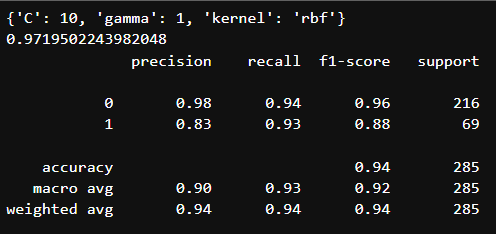

#### Training mit besten Parametern

In [ ]:
# Data preparation und Oversampling
X_train, X_test, y_train, y_test = train_test_split(df_modified.drop("Anwesenheit", axis=1), df_modified["Anwesenheit"], test_size=0.2, random_state=42)
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)

# initialisieren und trainieren von SVC
clf_best = SVC(C=1000, gamma=1,kernel="rbf", probability=True)
clf_best.fit(X_train_SMOTE, y_train_SMOTE)

# Modell speichern
dump(clf_best,'final_svc.joblib')

# Random Forest

In [ ]:
def pipeline(raw):
    lead = raw.loc[:,:'Datum']
    tail = raw.loc[:,'Temperatur':]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(tail)
    SimpleImputer()
    tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
    tail = tail.iloc[:14241,:]
    raw = pd.concat([lead, tail],axis=1)
    raw.drop(['index'], inplace=True, axis=1)
    raw['Datum'] = raw.Datum.astype('datetime64[ns]')
    raw['Minute'] = raw.Datum.dt.minute
    raw['Stunde'] = raw.Datum.dt.hour
    raw['Wochentag'] = raw.Datum.dt.day_name()
    try:
        Scaling = raw.drop(['Datum','Anwesenheit','Wochentag','Stunde', 'Minute'],axis=1)
    except:
        Scaling = raw.drop(['Datum','Wochentag','Stunde', 'Minute'],axis=1)
    scaler = StandardScaler()
    Scaling = pd.DataFrame(scaler.fit_transform(Scaling), columns = Scaling.columns)
    Rest = raw.drop(Scaling.columns,axis=1)
    raw = pd.concat([Scaling,Rest],axis=1)
    try:
        X = pd.get_dummies(raw.drop(['Datum','Anwesenheit'],axis = 1))
    except:
        X = pd.get_dummies(raw.drop(['Datum'],axis = 1))
    try:
        Y = raw['Anwesenheit']
    except:
        Y = None
    return X, Y

In [ ]:
# Vorverarbeitung
rfor_x,rfor_y = pipeline(raw)
# Train Test Split für Validierung
X_train, X_test, y_train, y_test = train_test_split(rfor_x, rfor_y, test_size=0.2, random_state=42)

Cross Validation for Hyperparameters: n_estimators, max_features, max_depth

In [ ]:
# Possible Hyperparameters:n_estimators = Number of trees, max_features = Number of Features, max_depth = Tiefe, in der der Baum generiert wird
param_grid = {'n_estimators':[10,100,200], #Default is 100
             'max_features':['sqrt','log2'], #Default ist sqrt, log2 other option
             'max_depth':[None,4,6]}, #Default is None, means depth until pure leaves are achieved
scores = ['accuracy', 'precision', 'recall']

gs = GridSearchCV(RandomForestClassifier(criterion = 'entropy', random_state=True), # control randomness of bootstrap/features during Hyperparam selection
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # recall as metric to evaluate best model
                )
gs.fit(X_train,y_train)

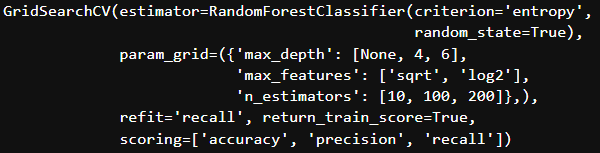

In [ ]:
print(f"Ergebnis der CV: \nBestes Modell ist {gs.best_estimator_} \nmit Hyperparametern {gs.best_params_} und einem Recall von {gs.best_score_}")

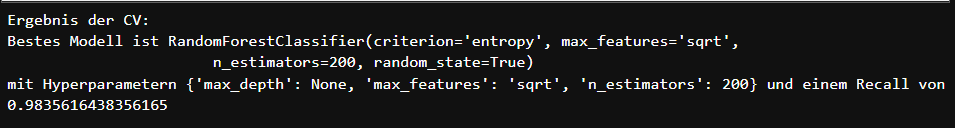

#### Trainieren mit besten Parametern

In [ ]:
#Use best hyperparams on complete train data set
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features = 'sqrt', random_state = True)
rf.fit(X_train, y_train)
# Evaluate performance on test data
y_pred = rf.predict(X_test)
print("Train Accuracy: ", rf.score(X_train, y_train), "Test Accuracy: ", rf.score(X_test, y_test))
print("Recall: ", recall_score(y_test, y_pred), "Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("Feature Importance: \n", pd.Series(rf.feature_importances_, index=rfor_x.columns).sort_values(ascending=False)) 

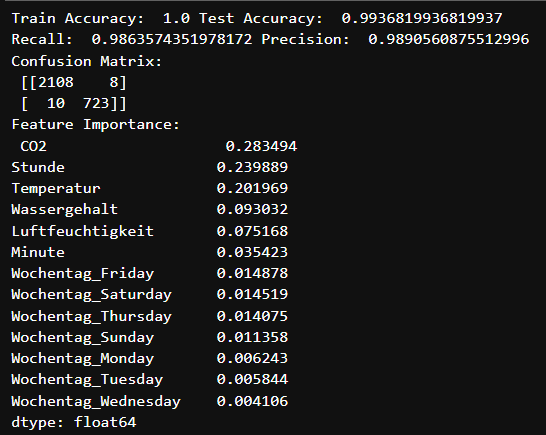